In [1]:
# General import
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import os
from PIL import Image
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
# Local import
from Codes.dataprocess import DataLoader
from Codes.dataprocess import Blurr
from Codes.dataprocess import Add_noise
from Codes.algoviolet import violetBD
from Codes.display import Display_ker
from Codes.display import Display_im
from Codes.display import Display_epd
from Codes.myfunc import nablah
from Codes.myfunc import convolve
from Codes.simplex import Simplex

# Minimisation fonction bi-convexe concave

On introduit le probleme d'optimisation biconvex-concave
de déconvolution aveugle d'images 
avec l' a priori de noyau de convolution régulier,

$$
\underset{u \in U ,K \in \Sigma}{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

L'espace $\Sigma$ correspond à l'ensemble des simplexes 
(ensemble des noyaux à coefficient positif dont la somme des coefficients vaut 1).
Par extension on notera $\Sigma$ la fonction indicatrice de cet ensemble.
L'espace $U$ correspond à l'hypercube $[0,1]^{N_x \times N_y}$, ou la boule unité pour la norme $L^\infty$.
Sa fonction indicatrice correspond donc à $\chi_{B,1}$.

La fonction à minimiser peut alors se réécrire

$$
\underset{u ,K }{\text{min}} \; \underset{v}{\text{sup}} \;
\frac{1}{2} \| g - K * u\|^2 
+ \chi_{B,1} (u)
+ \frac{1}{2} \alpha \| D K \|^2
+ \Sigma(K)
+\langle \nabla u , v \rangle
+ \chi_{B,\mu}(v)
\; .
$$

On note

$$
L =\frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \langle \nabla u , v \rangle
$$

Pour résoudre ce probleme d'optimisation on se propose de tester l'algorithme suivant,

$$
\left\{
\begin{align}
& \tilde{u}_{k+1} = \text{proj}_{B_1} \; (u_k - \tau \partial_u L(u_k,K_k,v_k) \; )\\
& K_{k+1} = \text{prox}_{\Sigma} \; (K_k - \gamma \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; )\\
& v_{k+1}         = \text{prox}_{B_\mu} \; (v_k + \sigma \partial_v L (u_{k+1},K_{k+1},v_k) \; )\\
& u_{k+1} = \tilde{u}_{k+1} + \theta_u (\tilde{u}_{k+1} - u_k) \quad \text{(relaxation)}
\end{align}
\right.
$$

Question :
est-ce qu'on met une relaxation aussi sur $K$ ?

$$
K_{k+1} = \tilde{K}_{k+1} + \theta_K (\tilde{K}_{k+1} - K_k)  \quad \text{(relaxation aussi ?)}
$$

On écrit alors les dérivées partielles de $L$,

$$
\left\{
\begin{align}
& \partial_u L(u_k,K_k,v_k) \; ) = \text{div} \cdot v_k - \tilde{K} * (g-K*u)\\
& \partial_K L(\tilde{u}_{k+1},K_k,v_k) \; ) = - (g-K*u)*\tilde{u} + \alpha D^TDK \\
& \partial_v L (u_{k+1},K_{k+1},v_k) \; ) =  \nabla u
\end{align}
\right.
$$

On trace les énergies primales et duales au cours de la minimisation

$$
\left\{
\begin{align}
& Ep = \frac{1}{2} \| g - K * u\|^2 
+ \frac{1}{2} \alpha \| D K \|^2
+ \mu. \text{TV} (u) \\
\\
& Ed = - \langle \nabla u ,v \rangle - \chi_{B,\mu}(v)
\end{align}
\right.
$$

In [2]:
file_name = 'Images'
im_name   = 'image01.png'
x_i = DataLoader(file_name,im_name)
x_i = x_i/np.amax(x_i)# Rescaling

In [3]:
M             = 40
gridx, gridy  = np.meshgrid(np.linspace(-1,1,2*M), np.linspace(-1,1,2*M))
gd            = np.sqrt(gridx*gridx+gridy*gridy)
sigma,moy     = 0.2, 0.0
K             = np.exp(-( (gd-moy)**2 / ( 2.0 * sigma**2 ) ) )
K             = K/np.sum(K)
K             = Simplex(K)

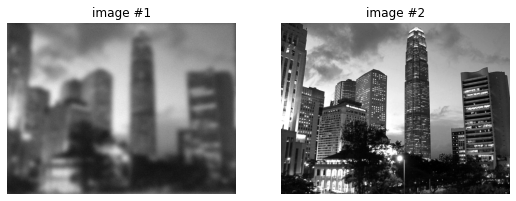

Erreur |x_pred - x_true|_2 :0.2724


In [5]:
x_b  = Blurr(x_i,K)
x_o1 = Add_noise(x_b,noise_level=0.05)
Display_im(x_o1,x_i,mysize=(9,5))

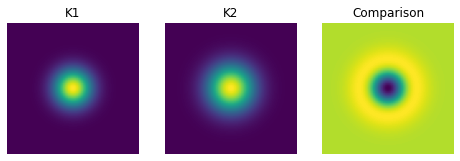

Erreur |K_pred - K_true|_2 : 0.2811 


In [6]:
sigma,moy  = 0.25, 0.0
K_shift    = np.exp(-( (gd-moy)**2 / ( 2.0 * sigma**2 ) ) )
K_shift    = K_shift/np.sum(K_shift)
K_shift    = Simplex(K_shift) # Simplex
Display_ker(K_shift,K,mysize=(8,4))

## Initialisation du noyau exacte - bruit std 0.05

Les erreurs initiales sont

$$
\begin{cases}
e_K = 0 \\
e_x = 0.2577
\end{cases}
$$

In [12]:
alpha = 0
mu    = 5
gamma = 1
K_in   = K.copy()
x_in  = x_o1
K_out,x_out,EpK,Epx,Ed = violetBD(K_in,x_in,x_b,\
                            alpha,mu,gamma,theta=1,\
                            niter=500,coeffK=0.1)

iteration 10 %--- gradient K 87285.1407 --- gradient x 10.8920
iteration 20 %--- gradient K 73213.2161 --- gradient x 9.6779
iteration 30 %--- gradient K 61554.8108 --- gradient x 8.6523
iteration 40 %--- gradient K 51904.0111 --- gradient x 7.7831
iteration 50 %--- gradient K 43930.9975 --- gradient x 7.0435
iteration 60 %--- gradient K 37360.4666 --- gradient x 6.4115
iteration 70 %--- gradient K 31959.8490 --- gradient x 5.8688
iteration 80 %--- gradient K 27533.6226 --- gradient x 5.4005
iteration 90 %--- gradient K 23916.0697 --- gradient x 4.9942
iteration 100 %--- gradient K 20967.0545 --- gradient x 4.6396
iteration 110 %--- gradient K 18567.9889 --- gradient x 4.3285
iteration 120 %--- gradient K 16619.5033 --- gradient x 4.0541
iteration 130 %--- gradient K 15035.1015 --- gradient x 3.8107
iteration 140 %--- gradient K 13742.8980 --- gradient x 3.5936
iteration 150 %--- gradient K 12685.7310 --- gradient x 3.3990
iteration 160 %--- gradient K 11813.5672 --- gradient x 3.2237


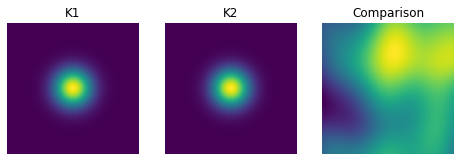

Erreur |K_pred - K_true|_2 : 0.0001 


In [13]:
Display_ker(K_out,K_in,mysize=(8,4))

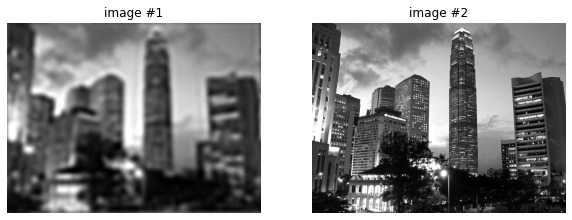

Erreur |x_pred - x_true|_2 :0.2513


In [14]:
Display_im(x_out,x_i,mysize=(10,5))

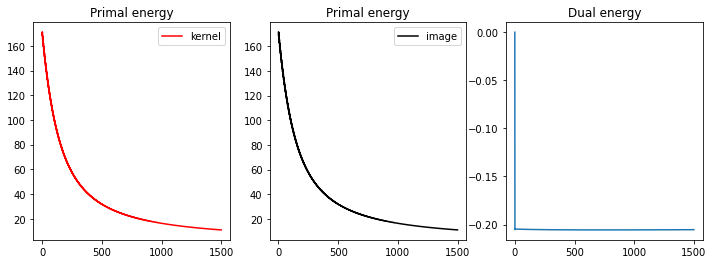

In [15]:
Display_epd(EpK,Epx,Ed)

## Initialisation noyau proche - pas de bruit
Les erreurs initiales sont

$$
\begin{cases}
e_K=0.2811 \\
e_x=0.2682
\end{cases}
$$

In [24]:
alpha     = 1
mu        = 0.5
gamma     = 1
K_in      = K_shift.copy()
x_in      = x_b
K_out,x_out,EpK,Epx,Ed = violetBD(K_in,x_in,x_b,\
                            alpha,mu,gamma,theta=1,\
                            niter=500,coeffK=50,coeffx=2,\
                            proj_simplex=False)

iteration 10 %--- gradient K 18226.6246 --- gradient x 3.1953
iteration 20 %--- gradient K 14282.2141 --- gradient x 2.0489
iteration 30 %--- gradient K 12463.9655 --- gradient x 1.5824
iteration 40 %--- gradient K 11412.8140 --- gradient x 1.3243
iteration 50 %--- gradient K 10646.6352 --- gradient x 1.1532
iteration 60 %--- gradient K 10069.7272 --- gradient x 1.0287
iteration 70 %--- gradient K 9544.7615 --- gradient x 0.9317
iteration 80 %--- gradient K 9081.3852 --- gradient x 0.8535
iteration 90 %--- gradient K 8676.4261 --- gradient x 0.7890
iteration 100 %--- gradient K 8310.0753 --- gradient x 0.7348
iteration 110 %--- gradient K 7985.7438 --- gradient x 0.6886
iteration 120 %--- gradient K 7694.4546 --- gradient x 0.6492
iteration 130 %--- gradient K 7430.8504 --- gradient x 0.6148
iteration 140 %--- gradient K 7181.4209 --- gradient x 0.5846
iteration 150 %--- gradient K 6966.2622 --- gradient x 0.5578
iteration 160 %--- gradient K 6780.8386 --- gradient x 0.5342
iteration 1

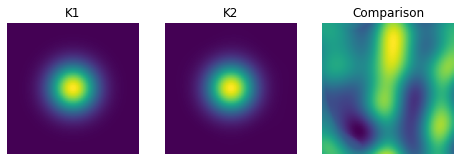

Erreur |K_pred - K_true|_2 : 0.0069 


In [25]:
Display_ker(K_out,K_in,mysize=(8,4))

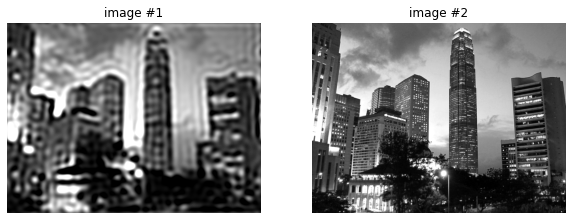

Erreur |x_pred - x_true|_2 :0.2667


In [26]:
Display_im(x_out,x_i,mysize=(10,5))

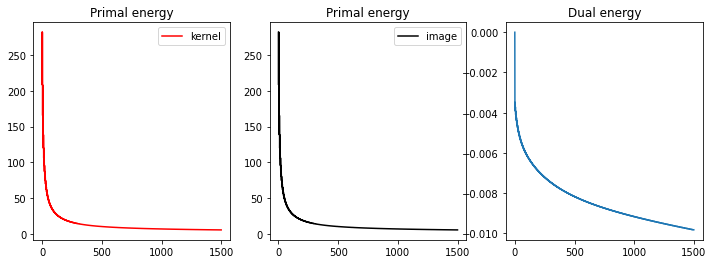

In [27]:
Display_epd(EpK,Epx,Ed)

## Initialisation noyau proche - bruit std 0.05
Les erreurs initiales sont

$$
\begin{cases}
e_K=0.2811 \\
e_x=0.2724
\end{cases}
$$

In [44]:
alpha = 1
mu    = 5
gamma = 1
K_in      = K_shift.copy()
x_in      = x_b
K_out,x_out,EpK,Epx,Ed = violetBD(K_in,x_in,x_o1,\
                            alpha,mu,gamma,theta=1,\
                            niter=500,coeffK=100,coeffx=1,\
                            proj_simplex=False)

iteration 10 %--- gradient K 68912.9927 --- gradient x 5.1682
iteration 20 %--- gradient K 19000.0608 --- gradient x 3.3769
iteration 30 %--- gradient K 15975.6929 --- gradient x 2.5716
iteration 40 %--- gradient K 14260.1941 --- gradient x 2.1136
iteration 50 %--- gradient K 13092.4265 --- gradient x 1.8204
iteration 60 %--- gradient K 12222.6792 --- gradient x 1.6159
iteration 70 %--- gradient K 11533.4822 --- gradient x 1.4637
iteration 80 %--- gradient K 10982.3671 --- gradient x 1.3452
iteration 90 %--- gradient K 10527.5818 --- gradient x 1.2489
iteration 100 %--- gradient K 10146.9361 --- gradient x 1.1680
iteration 110 %--- gradient K 9837.3844 --- gradient x 1.0992
iteration 120 %--- gradient K 9591.1399 --- gradient x 1.0394
iteration 130 %--- gradient K 9392.5425 --- gradient x 0.9871
iteration 140 %--- gradient K 9219.4652 --- gradient x 0.9407
iteration 150 %--- gradient K 9067.2797 --- gradient x 0.8991
iteration 160 %--- gradient K 8930.0323 --- gradient x 0.8617
iterati

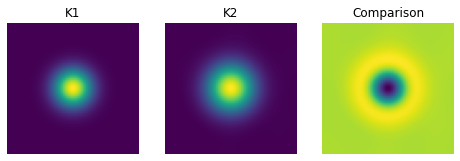

Erreur |K_pred - K_true|_2 : 0.2787 


In [45]:
Display_ker(K_out,K,mysize=(8,4))

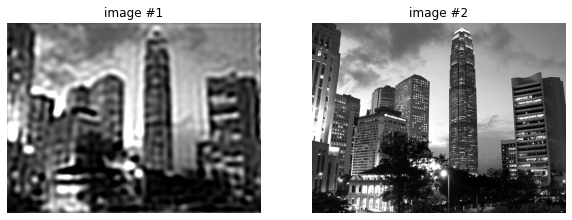

Erreur |x_pred - x_true|_2 :0.2606


In [46]:
Display_im(x_out,x_i,mysize=(10,5))

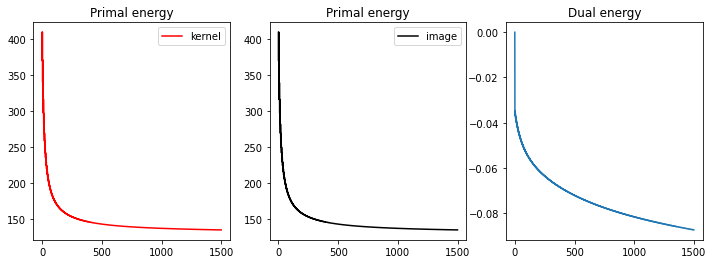

In [47]:
Display_epd(EpK,Epx,Ed)

### ANNEXES

In [ ]:
Nx,Ny = x_i.shape
# Kernel padding
K_pad = np.zeros(x_i.shape)
K_pad[Nx//2+1-M-2:Nx//2+M-1,Ny//2+1-M-2:Ny//2+M-1] = K
# Derivation padding
d      = -np.ones((3,3))
d[1,1] = 8
d_pad  = np.zeros((Nx,Ny))
d_pad[Nx//2-1:Nx//2+2,Ny//2-1:Ny//2+2] = d
# Parameters
alpha = 1*80**2
mu    = 1
gamma = 1
#
conv1 = convolve(K_pad,x_i)
conv2 = convolve(d_pad,K_pad)
ux,uy = nablah(x_i)
normu = np.abs(ux)+np.abs(uy)
#
Ep_b  = 0.5*gamma*np.linalg.norm(conv1-x_b)**2 \
          + 0.5*alpha*np.linalg.norm(conv2)**2\
          + mu/Nx/Ny*np.sum(normu)
Ep_o1  = 0.5*gamma*np.linalg.norm(conv1-x_o1)**2 \
          + 0.5*alpha*np.linalg.norm(conv2)**2\
          + mu/Nx/Ny*np.sum(normu)
print(" Min functionnal blurred : {:.6f},\
     \n Min functionnal noise   : {:.6f}".format(Ep_b,Ep_o1))